In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from robust_kalman import RobustKalman
from robust_kalman.utils import HuberScore, VariablesHistory, WindowStatisticsEstimator

# Example 1
## Define a linear state space model

In [3]:
dt = 0.01
end_time = 1.0
F = np.array([[1, dt], [0, 1]], np.float32)
G = np.array([[0.5 * dt**2, dt]], np.float32).T
H = np.array([[1, 0]], np.float32)
x0 = np.array([[0.01, 0.01]], np.float32).T
P0 = np.ones((2, 2), np.float32) * 0.001
sigma_process = 10.0
sigma_measure = 0.1
x0_kalman = np.array([[0, 0]], np.float32).T

In [4]:
Q0 = np.matmul(G, G.T) * sigma_process**2
R0 = np.eye(1, dtype=np.float32) * sigma_measure**2

## Create instance of the robust Kalman filter filter

In [5]:
kalman_linear = RobustKalman(F, None, H, x0_kalman, P0, Q0, R0, use_robust_estimation=False)
kalman_robust = RobustKalman(F, None, H, x0_kalman, P0, Q0, R0, use_robust_estimation=True)

## Initialize

In [6]:
x = x0
z = np.matmul(H, x0)
t_axis = np.arange(0, end_time, dt)

### Use this utility to track variables over time for plotting

In [7]:
history = VariablesHistory()

In [8]:
for t in t_axis:
    history.update('x', x)
    history.update('z', z)
    history.update('x_kalman', kalman_linear.current_estimate)
    history.update('x_kalman_robust', kalman_robust.current_estimate)

    q = np.random.normal(0.0, sigma_process, size=(1, 1))

    rare_event = 1 if np.random.uniform(0, 1.0) > 0.9 else 0
    r = np.random.normal(0.0, sigma_measure, size=(1, 1)) + np.random.choice([-1.0, 1.0]) * np.random.uniform(1.0, 1.5) * rare_event

    x = np.matmul(F, x) + np.matmul(G, q)
    z = np.matmul(H, x) + r

    kalman_linear.time_update()
    kalman_linear.measurement_update(z)
    kalman_robust.time_update()
    kalman_robust.measurement_update(z)

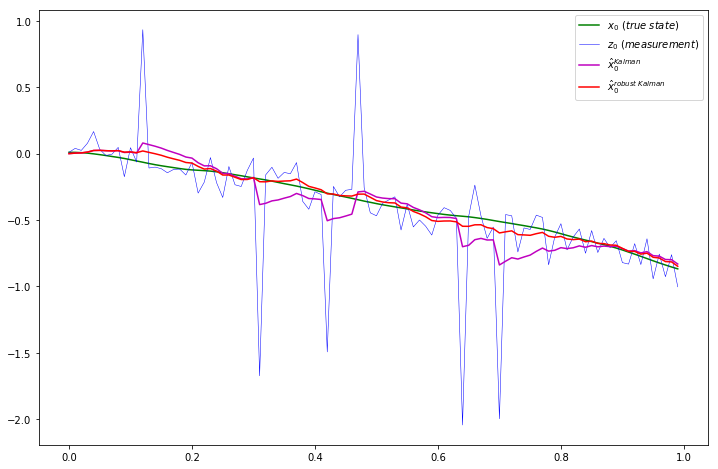

In [9]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

plt.plot(t_axis, [x[0, 0] for x in history['x']], 'g', label='$x_0\ (true\ state)$')
plt.plot(t_axis, [z[0, 0] for z in history['z']], 'b', linewidth=0.5, label='$z_0\ (measurement)$')
plt.plot(t_axis, [k[0, 0] for k in history['x_kalman']], 'm', label='$\hat{x}^{Kalman}_0$')
plt.plot(t_axis, [k[0, 0] for k in history['x_kalman_robust']], 'r', label='$\hat{x}^{robust\ Kalman}_0$')
plt.legend(loc='best')
plt.show()

# Example 2

In [10]:
dt = 0.01
end_time = 1.0
F = np.array([[1, dt], [0, 1]], np.float32)
G = np.array([[0.5 * dt**2, dt]], np.float32).T
H = np.array([[1, 0]], np.float32)
x0 = np.array([[0.01, 0.01]], np.float32).T
P0 = np.ones((2, 2), np.float32) * 0.001
sigma_process = 10.0
sigma_measure = 0.1
x0_kalman = np.array([[0, 0]], np.float32).T

In [11]:
IS_SPIKE_EXPERIMENT = True
PLOT_ADAPTIVE_CEE = True

In [12]:
Q0 = np.matmul(G, G.T) * sigma_process**2
R0 = np.eye(1, dtype=np.float32) * sigma_measure**2

In [13]:
kalman_linear = RobustKalman(F, None, H, x0_kalman, P0, Q0, R0, use_robust_estimation=False, use_adaptive_statistics=False)
kalman_robust = RobustKalman(F, None, H, x0_kalman, P0, Q0, R0, use_robust_estimation=True, use_adaptive_statistics=False)
kalman_robust_stat = RobustKalman(F, None, H, x0_kalman, P0, Q0, R0, use_robust_estimation=True, use_adaptive_statistics=True)

In [14]:
wstat_q = WindowStatisticsEstimator(win_size=25)
wstat_r = WindowStatisticsEstimator(win_size=25)

In [15]:
x = x0
z = np.matmul(H, x0)
cee_x = 0.0
cee_xres = 0.0
cee_xres_stat = 0.0
step = 2
t_axis = np.arange(0, end_time, dt)

In [16]:
history = VariablesHistory()

In [17]:
for t in t_axis:
    history.update('x', x)
    history.update('z', z)
    history.update('x_kalman', kalman_linear.current_estimate)
    history.update('x_kalman_robust', kalman_robust.current_estimate)
    history.update('x_kalman_robust_stat', kalman_robust_stat.current_estimate)
    cee_x += (np.linalg.norm(kalman_linear.current_estimate - x) / (np.linalg.norm(x) + 0.0001)) / step
    cee_xres += (np.linalg.norm(kalman_robust.current_estimate - x) / (np.linalg.norm(x) + 0.0001)) / step
    cee_xres_stat += (np.linalg.norm(kalman_robust_stat.current_estimate - x) / (np.linalg.norm(x) + 0.0001)) / step
    history.update('cee_x_history', cee_x)
    history.update('cee_xres_history', cee_xres)
    history.update('cee_xres_stat_history', cee_xres_stat)

    history.update('r_mean_est', kalman_robust_stat.r_mean_est)
    history.update('r_var_est', kalman_robust_stat.r_var_est)

    q = np.random.normal(0.0, sigma_process, size=(1, 1))
    if not IS_SPIKE_EXPERIMENT:
        r = 0.85 * np.random.normal(0.0, sigma_measure, size=(1, 1)) + 0.15 * np.random.normal(0.0, 5.0, size=(1, 1))
    else:
        rare_event = 1 if np.random.uniform(0, 1.0) > 0.9 else 0
        r = np.random.normal(0.0, sigma_measure, size=(1, 1)) + np.random.choice([-1.0, 1.0]) * np.random.uniform(1.0, 1.5) * rare_event #+ 0.15 * np.random.normal(0.0, 5.0, size=(1, 1))

    wstat_q.update(q)
    wstat_r.update(r)
    history.update('wstat_r_mean', wstat_r.mean())
    history.update('wstat_r_var', wstat_r.variance())

    x = np.matmul(F, x) + np.matmul(G, q)
    z = np.matmul(H, x) + r

    kalman_linear.time_update()
    kalman_linear.measurement_update(z)
    kalman_robust.time_update()
    kalman_robust.measurement_update(z)
    kalman_robust_stat.time_update()
    kalman_robust_stat.measurement_update(z)

    history.update('inov', kalman_robust.current_inovation)

    step += 1

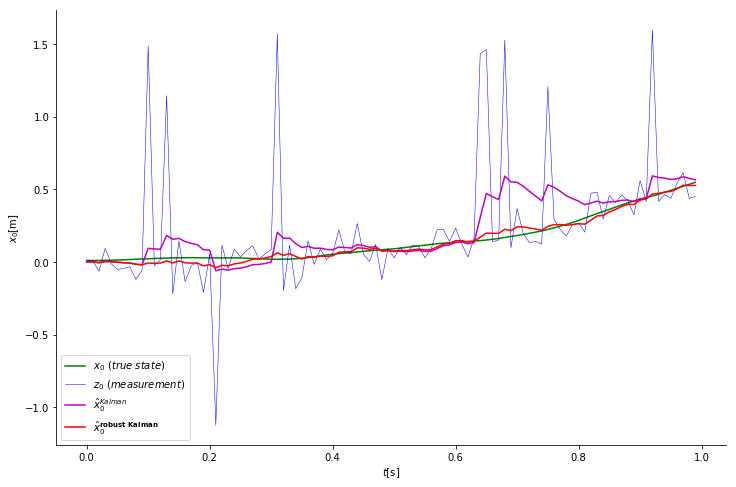

In [18]:
plt.plot(t_axis, [x[0, 0] for x in history['x']], 'g', label='$x_0\ (true\ state)$')
plt.plot(t_axis, [z[0, 0] for z in history['z']], 'b', linewidth=0.5, label='$z_0\ (measurement)$')
plt.plot(t_axis, [k[0, 0] for k in history['x_kalman']], 'm', label='$\hat{x}^{Kalman}_0$')
plt.plot(t_axis, [k[0, 0] for k in history['x_kalman_robust']], 'r', label=r'$\hat{x}^\mathbf{robust\ Kalman}_0$')
plt.xlabel(r'$t [\mathrm{s}]$')
plt.ylabel(r'$x_0 [\mathrm{m}]$')
plt.axis('tight')
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.legend()
if IS_SPIKE_EXPERIMENT:
    plt.savefig('x0_spike_outliers.pdf')
else:
    plt.savefig('x0_normal_outliers.pdf')

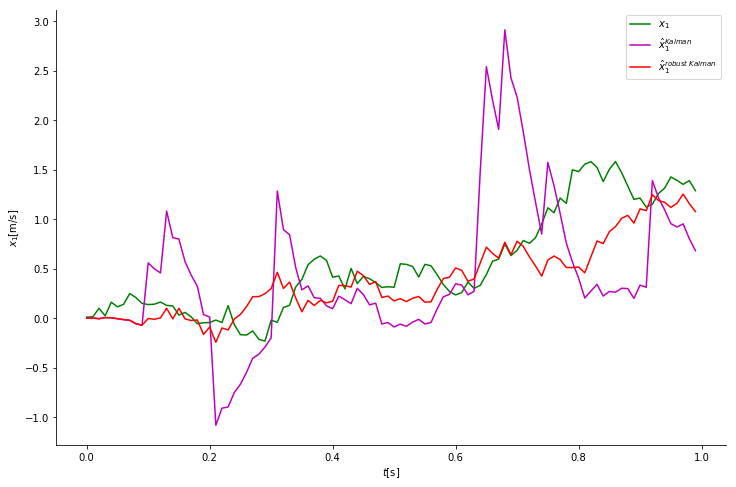

In [19]:
plt.plot(t_axis, [x[1, 0] for x in history['x']], 'g', label='$x_1$')
plt.plot(t_axis, [k[1, 0] for k in history['x_kalman']], 'm', label='$\hat{x}^{Kalman}_1$')
plt.plot(t_axis, [k[1, 0] for k in history['x_kalman_robust']], 'r', label='$\hat{x}^{robust\ Kalman}_1$')
plt.xlabel(r'$t [\mathrm{s}]$')
plt.ylabel(r'$x_1 [\mathrm{m/s}]$')
plt.axis('tight')
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.legend()
if IS_SPIKE_EXPERIMENT:
    plt.savefig('x1_spike_outliers.pdf')
else:
    plt.savefig('x1_normal_outliers.pdf')

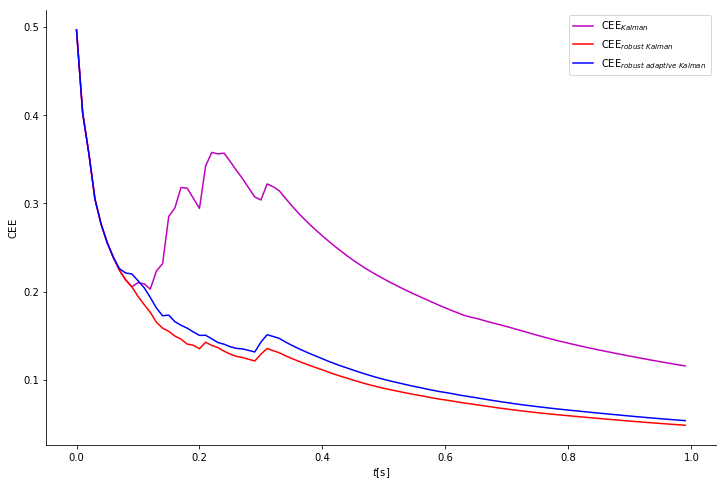

In [20]:
plt.plot(t_axis, history['cee_x_history'] / np.arange(1, len(history['cee_x_history']) + 1, 1), 'm', label='$\mathrm{CEE}_{Kalman}$')
plt.plot(t_axis, history['cee_xres_history'] / np.arange(1, len(history['cee_xres_history']) + 1, 1), 'r', label='$\mathrm{CEE}_{robust\ Kalman}$')
if PLOT_ADAPTIVE_CEE:
    plt.plot(t_axis, history['cee_xres_stat_history'] / np.arange(1, len(history['cee_xres_stat_history']) + 1, 1), 'b', label='$\mathrm{CEE}_{robust\ adaptive\ Kalman}$')
plt.xlabel(r'$t [\mathrm{s}]$')
plt.ylabel(r'$\mathrm{CEE}$')
plt.axis('tight')
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.legend()
if IS_SPIKE_EXPERIMENT:
    plt.savefig('cee_spike_outliers.pdf')
else:
    plt.savefig('cee_normal_outliers.pdf')

Text(0.5,1,'inovation')

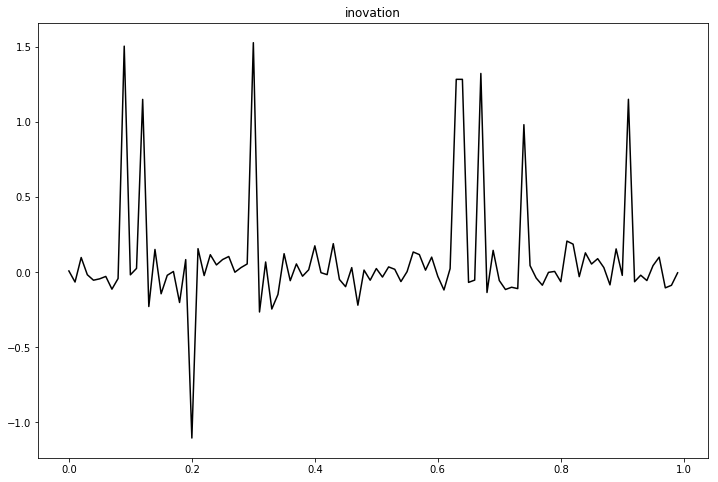

In [21]:
plt.plot(t_axis, [k[0, 0] for k in history['inov']], 'k')
plt.title('inovation')

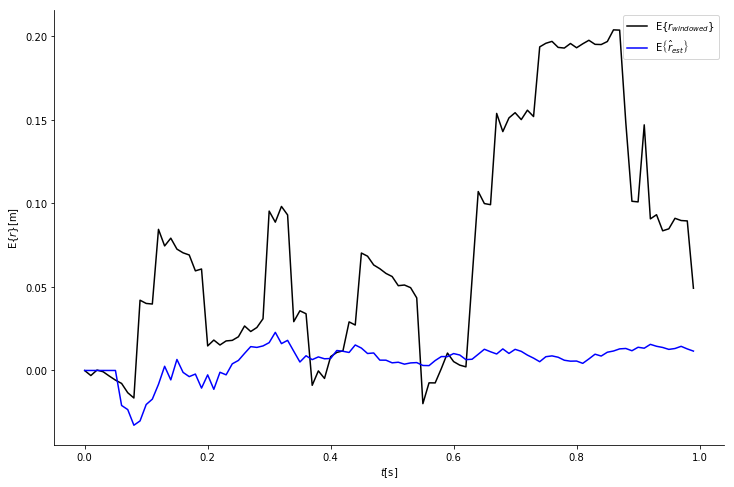

In [22]:
plt.plot(t_axis, history['wstat_r_mean'], 'k', label=r'$\mathrm{E}\left\{r_{windowed}\right\}$')
plt.plot(t_axis, history['r_mean_est'], 'b', label=r'$\mathrm{E}\left\{\hat{r}_{est}\right\}$')
plt.xlabel(r'$t [\mathrm{s}]$')
plt.ylabel(r'$\mathrm{E}\left\{r\right\} [\mathrm{m}]$')
plt.axis('tight')
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.legend()
if IS_SPIKE_EXPERIMENT:
    plt.savefig('r_mean_spike_outliers.pdf')
else:
    plt.savefig('r_mean_normal_outliers.pdf')

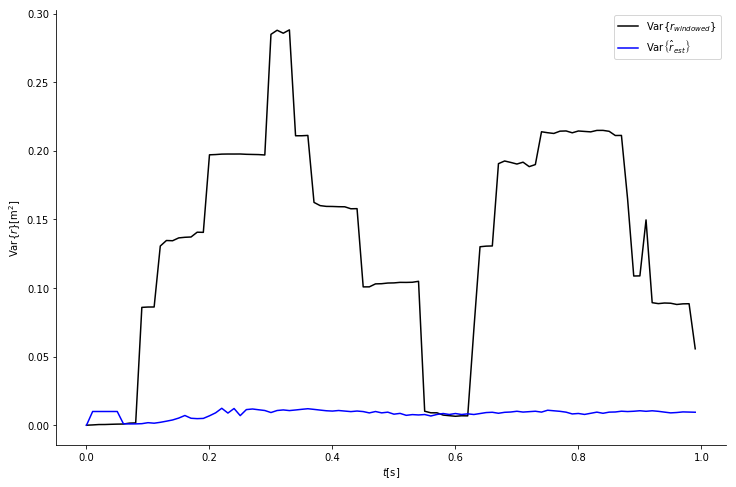

In [23]:
plt.plot(t_axis, history['wstat_r_var'], 'k', label=r'$\mathrm{Var}\left\{r_{windowed}\right\}$')
plt.plot(t_axis, history['r_var_est'], 'b', label=r'$\mathrm{Var}\left\{\hat{r}_{est}\right\}$')
plt.xlabel(r'$t [\mathrm{s}]$')
plt.ylabel(r'$\mathrm{Var}\left\{r\right\} [\mathrm{m^2}]$')
plt.axis('tight')
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.legend()
if IS_SPIKE_EXPERIMENT:
    plt.savefig('r_variance_spike_outliers.pdf')
else:
    plt.savefig('r_variance_normal_outliers.pdf')